In [1]:
from models_and_tools.ACGAN_paper import *
from models_and_tools.ACGAN_simple import *
from models_and_tools.functions import *

device = 'cuda'

Download your own model here:

In [2]:
netG = Generator(conf).to(device)
netD = Discriminator(conf).to(device)
# Load the weights back into the models
netG.load_state_dict(torch.load('netG200.pth'))
netD.load_state_dict(torch.load('netD200.pth'))
# Make sure to call eval() if you're in inference mode
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2d(128, 

Downloading a pretrained model to extract features from the generated images

In [3]:
# Load a pre-trained ResNet model
model = resnet50(pretrained=True).to(device)
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Removing the final layer
feature_extractor.eval()

C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Functions to geat features and cosine similarities

In [4]:


def get_features(image, feature_extractor):
	""" Convert image to tensor, normalize, and pass through the model """
	normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
	image = normalize(image).unsqueeze(0).to(device)  # Add batch dimension
	with torch.no_grad():
		features = feature_extractor(image)
	return features.flatten()


def cosine_similarity(feat1, feat2):
	""" Compute the cosine similarity between two feature vectors """
	return torch.nn.functional.cosine_similarity(feat1, feat2, dim=0)


def cosine_similarities(features1, features2):
	num_images = len(features1)
	similarities = []
	for i in range(num_images):
		sim = cosine_similarity(features1[i].cpu(), features2[i].cpu())
		similarities.append(sim)
	return similarities

Here we need to generate images using our models. For AC-GAN it's a little bit more complicated because we need labels. For other 2 models should be easier. Probably you don't even need the generate_images function.

In [5]:
num_images = 1000
fake_labels = torch.randint(0, conf.num_classes, (num_images,), device=device)
fake_labels2 = torch.randint(0, conf.num_classes, (num_images,), device=device)
generated_images1 = generate_images(netG, num_images, fake_labels)
generated_images2 = generate_images(netG, num_images, fake_labels2)


features1 = [get_features(image, feature_extractor) for image in generated_images1]
features2 = [get_features(image, feature_extractor) for image in generated_images2]

Calculating similarities

In [6]:
similarities = cosine_similarities(features1, features2)

Plotting the histogram with similarities

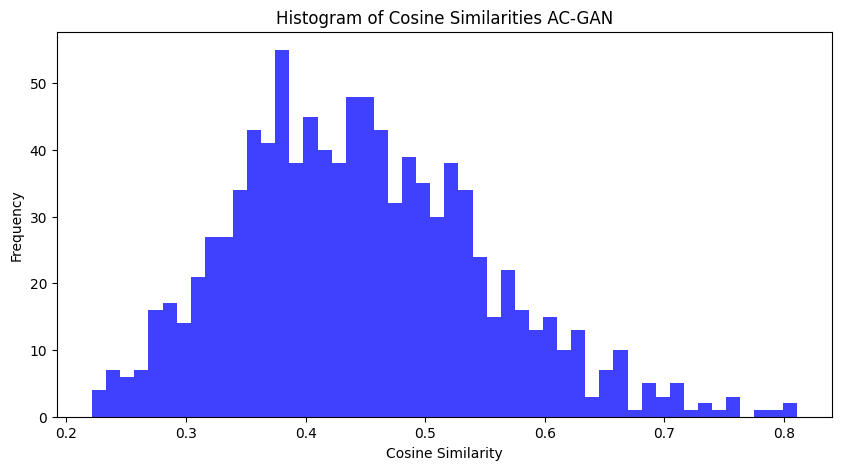

In [7]:
n_bins = 50  # You can change the number of bins based on how detailed you want the histogram to be
plt.figure(figsize=(10, 5))
plt.hist(similarities, bins=n_bins, alpha=0.75, color='blue')
plt.title('Histogram of Cosine Similarities AC-GAN')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.show()